<a href="https://colab.research.google.com/github/LDankert/ANNs-Tensorflow/blob/main/Homework5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# import the libraries that we need first
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import time

In [4]:
train_ds, test_ds = tfds.load('fashion_mnist', split=['train', 'test'], as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompletePCUCUU/fashion_mnist-train.tfrecord


  0%|          | 0/60000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompletePCUCUU/fashion_mnist-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


Data Pipeline

In [27]:


def preprocess_dataset(dataset):
  dataset = dataset.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
  dataset = dataset.map(lambda img, target: (tf.cast(img, tf.float32), (tf.cast(target, tf.float32))))
  dataset = dataset.map(lambda img, target: ((img/128.)-1., target))
  dataset = dataset.shuffle(buffer_size=1000) 
  dataset = dataset.batch(32)
  dataset = dataset.prefetch(12)
  return dataset

training_ds = train_ds.apply(preprocess_dataset)
testing_ds = test_ds.apply(preprocess_dataset)


In [21]:
training_ds, testing_ds

(<PrefetchDataset shapes: ((None, 28, 28, 1), (None, 10)), types: (tf.float32, tf.float32)>,
 <PrefetchDataset shapes: ((None, 28, 28, 1), (None, 10)), types: (tf.float32, tf.float32)>)

Model

In [40]:
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer

class Model(Model):

  def __init__(self):
    super(Model, self).__init__()
    self.layers_list = [
                        layers.Conv2D(32, kernel_size=(3,3), activation='relu', padding='same', 
                                      kernel_regularizer=tf.keras.regularizers.l2, input_shape=(28, 28, 1)
                                      ),
                        layers.BatchNormalization(),
                        layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same', 
                                      kernel_regularizer=tf.keras.regularizers.l2
                                      ),
                        layers.BatchNormalization(),
                        layers.MaxPooling2D(pool_size=(2,2)),
                        layers.Dropout(0.20),

                        layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same', 
                                      kernel_regularizer=tf.keras.regularizers.l2
                                      ),
                        layers.BatchNormalization(),
                        layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same', 
                                      kernel_regularizer=tf.keras.regularizers.l2
                                      ),
                        layers.BatchNormalization(),
                        layers.MaxPooling2D(pool_size=(2,2)),
                        layers.Dropout(0.30),

                        layers.Conv2D(128, kernel_size=(3,3), activation='relu', padding='same', 
                                      kernel_regularizer=tf.keras.regularizers.l2
                                      ),
                        layers.BatchNormalization(),
                        layers.Conv2D(128, kernel_size=(3,3), activation='relu', padding='same', 
                                      kernel_regularizer=tf.keras.regularizers.l2
                                      ),
                        layers.BatchNormalization(),
                        layers.MaxPooling2D(pool_size=(2,2)),
                        layers.Dropout(0.40),

                        layers.Flatten(),

                        layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2),
                        layers.Dropout(0.30),

                        layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2),
                        layers.Dropout(0.20),

                        layers.Dense(10, activation='softmax') 
                        ]
                        
  def call(self, x, training = True):
      for layer in self.layers_list:
        x = layer(x, training=training)
      return x  

Training

In [43]:


#change in loss function and accuracy
def train_step(model, input, target, loss_function, optimizer):

  with tf.GradientTape() as tape:
    prediction = model(input)
    train_loss = loss_function(target, prediction) #hier noch ändern
    gradients = tape.gradient(train_loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  
  return train_loss

def test(model, test_data, loss_function):
  # test over complete test data
  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction) #tf.keras.losses.BinaryCrossentropy()
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1) #np.round(,0)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [45]:
tf.keras.backend.clear_session()

# Hyperparameters
num_epochs = 10
learning_rate = 0.1

start = time.time()

# Initialize the model.
model = Model()
# Initialize the loss: categorical cross entropy. 
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: SGD with default parameters. 
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Initialize lists for later visualization.
train_losses = []
train_accuracies = []

test_losses = []
test_accuracies = []

# Testing once before we begin.
test_loss, test_accuracy = test(model, testing_ds, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

# Check how model performs on train data once before we begin.
train_loss = test(model, training_ds, cross_entropy_loss)
train_losses.append(train_loss)
train_accuracies.append(train_accuracy)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')

    # Training (and checking in with training).
    epoch_loss_agg = []
    epoch_acc_agg = []
    for input, target in training_ds:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss)
        epoch_acc_agg.append(train_accuracy)
    
    # Track training loss and accuracy.
    train_losses.append(tf.reduce_mean(epoch_loss_agg))
    train_accuracies.append(tf.reduce_mean(epoch_acc_agg))

    # Testing
    test_loss, test_accuracy = test(model, testing_ds, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

end = time.time()
execution_time = int((end - start)/60)

print(f'Execution time: {execution_time} minutes and {execution_time % 60} seconds.')

Epoch: 0 starting with accuracy 0.10672923322683706
Epoch: 1 starting with accuracy 0.8578274760383386
Epoch: 2 starting with accuracy 0.8791932907348243
Epoch: 3 starting with accuracy 0.8962659744408946
Epoch: 4 starting with accuracy 0.891573482428115
Epoch: 5 starting with accuracy 0.902555910543131
Epoch: 6 starting with accuracy 0.9087460063897763
Epoch: 7 starting with accuracy 0.9131389776357828
Epoch: 8 starting with accuracy 0.9119408945686901
Epoch: 9 starting with accuracy 0.917132587859425
Execution time: 126 minutes and 6 seconds.


Visualisation

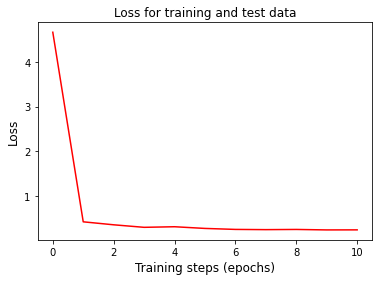

In [50]:
plt.figure()
#line1, = plt.plot(train_losses, color = 'blue')
line2, = plt.plot(test_losses, color = 'red')
#line3, = plt.plot(validation_losses, color = 'yellow')
plt.xlabel("Training steps (epochs)", fontsize = 12)
plt.ylabel("Loss", fontsize = 12)
#plt.legend((line1, line2, line3),("training", "test", "validation"))
plt.title('Loss for training and test data')
plt.show()

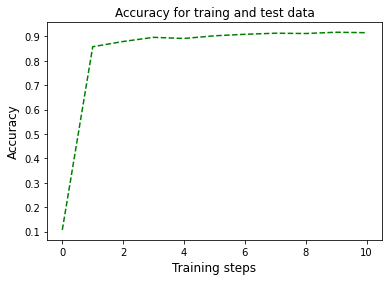

In [51]:
plt.figure()
#line1, = plt.plot(train_accuracies, linestyle = 'dashed', color = 'orange')
line2, = plt.plot(test_accuracies, linestyle = 'dashed', color = 'green')
#line3, = plt.plot(test_accuracies, linestyle = 'dashed', color = 'blue')
plt.xlabel("Training steps", fontsize = 12)
plt.ylabel("Accuracy", fontsize = 12)
#plt.legend((line1, line2, line3),("training", "test", "validation"))
plt.title('Accuracy for traing and test data')
plt.show()